# TP -  Introduction to Pytorch


## Tensors, Back-propagation, Hand-written digit recognition,  Language modeling
*************************************************************

**Recommended Reading:**

http://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html

## Dans ce fichier se trouve notre solution pour l'exercice MNIST du TP d'intro.

Une version en TensorFlow est décrite sur http://blog.xebia.fr/2017/04/11/tensorflow-deep-learning-episode-3-modifiez-votre-reseau-de-neurones-en-toute-simplicite/ 

# MNIST

Vous allez maintenant utiliser les fonctions haut niveau de pytorch: torch.nn, torch.optim etc. Des exemples d'implémentation d'un réseau de neurones sont trouvables sur
 
 http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
 
 http://blog.gaurav.im/2017/04/24/a-gentle-intro-to-pytorch/
 
 http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
 
 http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/210_Convolution_MNIST.html#convolutionmnistrst
 
 http://blog.xebia.fr/2017/04/11/tensorflow-deep-learning-episode-3-modifiez-votre-reseau-de-neurones-en-toute-simplicite/ (en TensorFlow)
 

On commence par charger les données:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch.utils.data as data
from PIL import Image
import os
import os.path
import errno
import torch
import codecs

from torchvision import datasets, transforms

mnist_folder = './MNIST_data/'

train_data = datasets.MNIST(root=mnist_folder, download=True, transform=transforms.ToTensor(), train=True)
test_data = datasets.MNIST(root=mnist_folder, download=True, transform=transforms.ToTensor(), train=False)

In [3]:
print("Nombre d'images dans le train set:", len(train_data))
print("Nombre d'images dans le train set:", len(test_data))

Nombre d'images dans le train set: 60000
Nombre d'images dans le train set: 10000


### Afficher quelques images

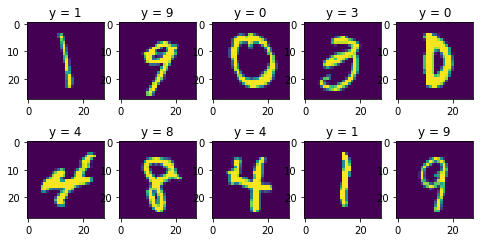

In [100]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(8, 4), squeeze=False)
seed = 733 # changer la seed pour afficher d'autres images

for i in range(10):
    r = i // 5
    c = i % 5
    np.random.seed(seed+i)
    idx = np.random.choice(len(train_data), 1)[0]
    x = train_data[idx][0].numpy() # numpy array de dim 3, avec 1*28*28 valeurs dans [0, 1]
    y = train_data[idx][1] # numéro entre 0 et 9
    axes[r, c].imshow(x[0, :, :])
    axes[r, c].set_title('y = {}'.format(y))
    
plt.show()

### Modèle initial

In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

# Training settings
seed = 1337
lr = 0.1
epochs = 25
train_batch_size = 10
test_batch_size = 100

torch.manual_seed(seed)

train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True) # crée des racks de 10 images
test_loader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 10)
        

    def forward(self, X):
        X = X.view(-1, 28*28)  # transforme une image 28*28 en ligne de 784 valeurs
        X = self.fc1(X)
        return F.log_softmax(X)

model = Net()

optimizer = optim.SGD(model.parameters(), lr=lr) 

def train(epoch):

    exp_loss = 0.
    n_processed = 0

    model.train()
    for X, Y in train_loader:
        X, Y = Variable(X), Variable(Y)
        
        # Forward pass
        Y_pred_prob = model(X)

        # Compute expected loss
        loss = F.nll_loss(Y_pred_prob, Y)
        
        # Backward pass
        loss.backward()
        
        # Parameter update (gradient descent)
        optimizer.step()
        optimizer.zero_grad()

        # exp_loss.data[0] += loss * X.data.shape[0]
        exp_loss += loss * X.data.shape[0]
        n_processed += X.data.shape[0]
    
    exp_loss /= n_processed
    return exp_loss

def test():
    test_loss = 0
    test_error = 0
    
    model.eval()
    for X, Y in test_loader:
        X, Y = Variable(X, volatile=True), Variable(Y)
        
        # Forward pass
        Y_pred_prob = model(X)
        
        # Compute the expected negative log-likelihood
        test_loss += F.nll_loss(Y_pred_prob, Y, size_average=False).data[0]
        
        # Get the mode of p(y|x) (most probable digit)
        Y_pred = Y_pred_prob.data.max(1, keepdim=True)[1]
        
        # Compute the expected 0/1 error
        test_error += (1 - Y_pred.eq(Y.data.view_as(Y_pred))).sum()

    test_loss /= len(test_loader.dataset)
    test_error /= len(test_loader.dataset)

    return test_loss, test_error


for epoch in range(1, epochs + 1):
    
    print('Epoch {}...'.format(epoch))
    
    train_loss = train(epoch)
    print('Train negative log-likelihood: {:.6f}'.format(train_loss.data[0]))
    
    test_loss, test_error = test()
    print('Test  negative log-likelihood: {:.6f} 0/1 error: {:.6f}'.format(test_loss, test_error))


Epoch 1...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train negative log-likelihood: 0.362772
Test  negative log-likelihood: 0.294563 0/1 error: 0.083200
Epoch 2...
Train negative log-likelihood: 0.302695
Test  negative log-likelihood: 0.290107 0/1 error: 0.080900
Epoch 3...
Train negative log-likelihood: 0.291658
Test  negative log-likelihood: 0.288073 0/1 error: 0.079500
Epoch 4...
Train negative log-likelihood: 0.285517
Test  negative log-likelihood: 0.299710 0/1 error: 0.081800
Epoch 5...
Train negative log-likelihood: 0.281135
Test  negative log-likelihood: 0.277646 0/1 error: 0.075900
Epoch 6...
Train negative log-likelihood: 0.278610
Test  negative log-likelihood: 0.289195 0/1 error: 0.083600
Epoch 7...
Train negative log-likelihood: 0.275453
Test  negative log-likelihood: 0.291415 0/1 error: 0.083400
Epoch 8...
Train negative log-likelihood: 0.272424
Test  negative log-likelihood: 0.274635 0/1 error: 0.076400
Epoch 9...
Train negative log-likelihood: 0.271329
Test  negative log-likelihood: 0.292795 0/1 error: 0.079300
Epoch 10...


Jouez avec les paramètres suivants:
- lr
- epochs
- train_batch_size

Quelle est la meilleure performance (0/1 error) que vous arrivez à atteindre?

Les résultats selon la configuration :

(lr = 0.1, epochs = 25, train_batch_size = 50 ) : Train negative log-likelihood: 0.255545,     Test negative log-likelihood: 0.267748,      0/1 error: 0.075300

(lr = 0.5, epochs = 25, train_batch_size = 50 ) : Train negative log-likelihood: 0.260592, Test  negative log-likelihood: 0.288959, 0/1 error: 0.081400

(lr = 0.1, epochs = 25, train_batch_size = 10 ) : Train negative log-likelihood: 0.257962, Test  negative log-likelihood: 0.284569, 0/1 error: 0.078700

(lr = 0.1, epochs = 50, train_batch_size = 50 ) : Train negative log-likelihood: 0.245841, Test  negative log-likelihood: 0.265342, 0/1 error: 0.073600

(lr = 0.05, epochs = 50, train_batch_size = 10 ) : Train negative log-likelihood: 0.243141, Test  negative log-likelihood: 0.271344, 0/1 error: 0.074000

L'erreur 0-1 minimale obtenue correspond à 7,36 % de mal classés.

## Améliorez votre modèle

Améliorez votre modèle afin de diminuer l'erreur sur le jeu de test. Essayez différentes architectures / hyperparamètres et à chaque fois reportez vos résultats. Des exemples sont décrits sur la page officielle de PyTorch http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html ainsi que sur https://gist.github.com/reddragon/3fa9c3ee4d10a7be242183d2e98cfc5d.

Objectif: passer sous les 1% d'erreur: http://yann.lecun.com/exdb/mnist/

Pistes à essayer:
- plus de couches cachées. On affiche les taux d'erreurs de réseaux de neurones à 1, 2 et 3 couches et sur 25 epochs : ![3 couches cachées](graphique_couches.png)
Le taux d'erreur en dents de scie suggère de diminuer le taux d'apprentissage en fonction de la valeur de perte.


- convolutions + max pooling. Voir http://pytorch.org/docs/master/nn.html#conv2d + http://pytorch.org/docs/master/nn.html#maxpool2d. Une brève description du principe de convolution (2D ici, qui est une application de la convolution sur $\mathbb{Z}^2$ au sens mathématique si le terme de biai est absent) est tirée de https://arxiv.org/pdf/1603.07285.pdf : On transforme un tenseur 2D de valeurs en remplaçant chaque entrée par une somme pondérée des valeurs dans une fenêtre autour de cette entrée, plus un terne de biai. Les poids et le biai sont des termes calibrés par l'apprentissage. Un coefficient de stride s > 1 signifie que l'on applique une convolution usuelle puis on ne garde que 1 entrée sur s du tenseur de sortie dans les 2 directions. Un nombre $N_{in}$ de canaux en entrée signifie autant de Tenseurs 2D à traiter, tandis que $N_{out}$ canaux en sortie signifie autant de tenseurs à créer, ce qui implique $N_{in}*N_{out}$ noyaux de convolutions à utiliser. Le max-pooling suit un principe similaire, mais fournit la valeur max dans une fenêtre autour d'une entrée au lieu d'une somme pondérée dans cette fenêtre.

 Les graphiques suivant montrent la succession d'une couche de convolution sur une fenêtre 5 par 5 suivie d'un max pooling sur une fenêtre 2 par 2, où on a de gauche à droite un nombre de canaux de sortie de convolution égal à 1, 5 et 10, suivie de deux couches cachées de neurones. On constate que l'ajout d'une couche de convolution avec un seul canal en sortie derrière 2 couches de neurones n'améliore pas la performance (c'est assez normal puisque cela ne fait que 'flouter' les images), et que spécifier plusieurs canaux de sortie est la caractéristique clé pour améliorer les performances. En effet, avec l'ajout de canaux on frise le 99 % de réussites (graphique de droite) : ![3 couches cachées](graphique_convo_maxpooling_couches.png)
 

- dropout. Voir la brève explication sur http://pytorch.org/docs/master/nn.html#dropout2d ainsi que l'article https://arxiv.org/pdf/1411.4280.pdf . Le principe du dropout est de modifier un tenseur en posant la valeur de chaque élément comme égale à 0 avec probabilité $p \in [0,1]$, avec p un paramètre défini au préalable. L'objectif de ceci est de corriger une possible dépendance trop forte de l'apprentissage aux valeurs de quelques 'pixels' en particulier, et ainsi tourner l'apprentissage sur des formes globales des images d'entrainement. En fixant comme paramètre "d'évacuation" la valeur p = 0.2 (à gauche), puis en intégrant une diminution adaptative du taux d'apprentissage (au centre) et enfin en ajoutant une descente de gradient par Adam on obtient ![3 couches cachées](graphique_conv_maxpooling_dropout_couches.png)


- couches résiduelles

Astuces:
- changer l'algorithme de descente de gradient (Adam)
- implémentez une stratégie d'early stopping: $n$ epochs sans amélioration -> arret
- implémentez une stratégie de diminution du learning rate: $n/2$ epochs sans amélioration -> $\alpha = \alpha / 2$

A propos de la différence entre définir des opérations dans le réseau dans la partie init ou la partie forward, voir https://discuss.pytorch.org/t/how-to-choose-between-torch-nn-functional-and-torch-nn-module/2800/14 

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [159]:
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())

None
False


In [ ]:
# La liste des optimiseurs
'SGD' : optim.SGD(params, lr=lr),
'ASGD' : optim.ASGD(params, lr=0.01, lambd=0.0001, alpha=0.75, t0=1000000.0, weight_decay=0), 
'Adadelta' : optim.Adadelta(params, lr=0.01, rho=0.9, eps=1e-06, weight_decay=0),
'Adagrad' : optim.Adagrad(params, lr=0.01, lr_decay=0, weight_decay=0),
'Adam' : optim.Adam(params, lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0), 
'Adamax' : optim.Adamax(params, lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0),
'RMSp' : optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False),
'Rp' : optim.Rprop(params, lr=0.01, etas=(0.5, 1.2), step_sizes=(1e-06, 50))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


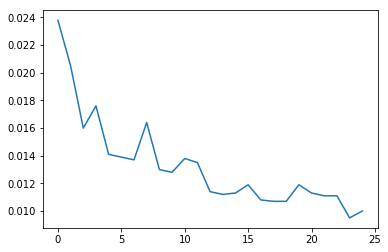

In [21]:
#--------------- Paramètres de base de l'apprentissage --------------
seed = 1337
lr = 0.05
epochs = 25
train_batch_size = 10
test_batch_size = 100
torch.manual_seed(seed)
train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False)



#----------------------- Le modèle -----------------------------------
class Net(nn.Module):
    def __init__(self): # Définit la structure du réseau de neurones
        super(Net, self).__init__()
        
        # les convolutions, 
        self.conv1 = nn.Conv2d(1,10,5)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout2d(p=0.2)
        
        self.fc1 = nn.Linear(1440, 40) #10*12*12 = 1440
        self.fc2 = nn.Linear(40, 20)
        self.fc3 = nn.Linear(20, 10) 

    def forward(self, X): # Fait circuler la donnée dans le réseau construit en __init__
        
        # convolution + Max pooling
        X = self.conv1(X)
        X = F.relu(X)
        X = self.pool(X)
        X = self.dropout(X)
        
        X = X.view(-1, self.num_flat_features(X))  # flatten images 
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X) 
    
    def num_flat_features(self, X):
        size = X.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

model = Net()



# ------------------------ Méthode d'optimisation des paramètres du modèle --------------------
params = model.parameters()

# l'optimiseur : définit comment les paramètres sont optimisés à partir du gradient de l'erreur stocké dans ces paramètres
# infos sur http://pytorch.org/docs/master/optim.html
# voir peut être aussi http://www.cs.toronto.edu/~fritz/absps/momentum.pdf

# 'SGD' : stochastic gradient descent
# 'ASGD' : averaged stochastic gradient descent
# 'Adadelta' : 12-2012, https://arxiv.org/pdf/1212.5701.pdf
# 'Adagrad' : 07-2012, http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf
# 'Adam' : 12-2014, https://arxiv.org/pdf/1412.6980.pdf
# 'Adamax'
# 'RMSp' 
# 'Rp'     
optimizer = optim.SGD(params, lr=lr) #  optim.Adam(params, lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0) #optim.SGD(params, lr=lr) #




# réduction du taux d'apprentissage en fonction de la valeur de gradient scheduler 
# Explications dans http://pytorch.org/docs/master/_modules/torch/optim/lr_scheduler.html
# mettre un 'max' si on maximise un gain dans l'apprentissage 

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 5, verbose  = False)



#---------------- Fonction d'apprentissage ----------------------------
def train(epoch):

    exp_loss = 0.
    n_processed = 0

    model.train()
    for X, Y in train_loader:
        X, Y = Variable(X), Variable(Y)
        
        # Calcul de la sortie prédite par le modèle
        Y_pred_prob = model(X)

        # Calcul de l'erreur
        loss = F.nll_loss(Y_pred_prob, Y)

        # Rétro-propagation du gradient de l'erreur dans les paramètres
        loss.backward()
        
        # Applique la mise à jour des paramètres (descente de gradient)
        optimizer.step()
        
        # Modifie le taux d'apprentissage de l'optimiseur en fonction de l'importance de l'erreur
        #scheduler.step(loss.data[0])
        
        # Initialisation du gradient
        optimizer.zero_grad()

        # Paramètres pour la perte moyenne
        exp_loss += loss * X.data.shape[0]
        n_processed += X.data.shape[0]
    
    exp_loss /= n_processed
    return exp_loss



#----------------------- Fonction de test --------------------------------
def test():
    test_loss = 0
    test_error = 0
    
    model.eval()
    for X, Y in test_loader:
        X, Y = Variable(X, volatile=True), Variable(Y)
        
        # Forward pass
        Y_pred_prob = model(X)
        
        # Compute the expected negative log-likelihood
        test_loss += F.nll_loss(Y_pred_prob, Y, size_average=False).data[0]
        
        # Get the mode of p(y|x) (most probable digit)
        Y_pred = Y_pred_prob.data.max(1, keepdim=True)[1]
        
        # Compute the expected 0/1 error
        test_error += (1 - Y_pred.eq(Y.data.view_as(Y_pred))).sum()

    test_loss /= len(test_loader.dataset)
    test_error /= len(test_loader.dataset)

    return test_loss, test_error



#-------------------- Apprentissage du réseau -------------------------
LOSS = []
for epoch in range(1, epochs + 1):
    
    #print('Epoch {}...'.format(epoch))
    #print('Train negative log-likelihood: {:.6f}'.format(train_loss.data[0]))
    #print('Test  negative log-likelihood: {:.6f} 0/1 error: {:.6f}'.format(test_loss, test_error))
    
    train_loss = train(epoch)
    test_loss, test_error = test()
    scheduler.step(test_loss)
    LOSS.append(test_error)
    if epoch % 5 == 0:
        print(epoch)
    

plt.plot(range(epochs), LOSS)


In [27]:
LOSS_29 = list(LOSS)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


30
31
32
33
34
35
36
37
38
39


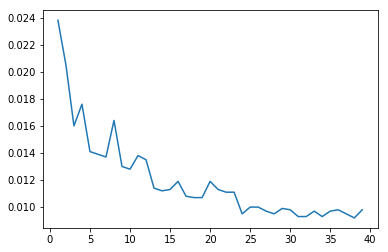

In [28]:
for epoch in range(30, 40):
    
    #print('Epoch {}...'.format(epoch))
    #print('Train negative log-likelihood: {:.6f}'.format(train_loss.data[0]))
    #print('Test  negative log-likelihood: {:.6f} 0/1 error: {:.6f}'.format(test_loss, test_error))
    
    train_loss = train(epoch)
    test_loss, test_error = test()
    scheduler.step(test_loss)
    LOSS.append(test_error)
    print(epoch)
    

plt.plot(range(1,len(LOSS)+1), LOSS)

In [31]:
LOSS_40 = list(LOSS)

On arrive donc à un taux d'erreurs inférieur à 1%.